# 根据tracin_xxx得到的TXT文件，对模型进行训练，并保存数据到tensorboard

In [1]:
import utils
from torchvision import transforms
import my_dataset
import os
import torch
from tqdm import tqdm
from models.vit import ViT
from torch.utils.tensorboard import SummaryWriter
from models_DLA.dla_simple import SimpleDLA

## 选取训练数据

$$
Train_{tracin} = \sum_{i = 0}({Train_{sorted}}[Segment[i].head:Segment[i].rear]).Sample(Segment[i].sample)
$$

In [2]:
# 从第cp*10个checkpoint开始训练
cp = 2

segments = [
    [0, 8000, 7000],
    [8000, 15000, 2500],
    [33000, 35000, 1000]
]

save = True

In [3]:
# 读取训练数据和测试数据，其中tracin_file2文件夹中的文件是根据tracin进行排序后的
train_data = utils.read_file("./train_result_DLA/forget/easy_" + str(cp) + "0.txt")
val_data = utils.read_file("../cifar10/test_data.txt")

In [4]:
# 根据segment得到训练数据
train_data_tracin = []

for i, segment in enumerate(segments):
    train_data_tracin += utils.split_easy_hard_num(train_data, segment[0], segment[1],segment[2])

# index = np.zeros(len(train_data_tracin))
# y = np.ones(len(train_data_tracin))
# for i2, data in enumerate(train_data_tracin):
#     index[i2] = train_data.index(data)
# plt.figure(figsize=(3,15),dpi=100)
# color = [plt.get_cmap("Spectral", len(train_data))(int (i)) for i in index]
# plt.scatter(y, index, s = 0.1, c = color)
# plt.xticks([]) 
# plt.ylim((0,len(train_data)))
# plt.colorbar()

# plt.show()

train_data = train_data_tracin
    
description = "EPOCH:" + str(cp*10) + utils.get_description(train_data, segments) + "_E_F"
print(description)

EPOCH:20*TOTAL:10500*[0--8000]->7000&[8000--15000]->2500&[33000--35000]->1000_E_F


In [5]:
# tensorboard
writer = SummaryWriter(log_dir = 'logs_forget')

In [6]:
batch_size = 64

nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

Using 8 dataloader workers every process


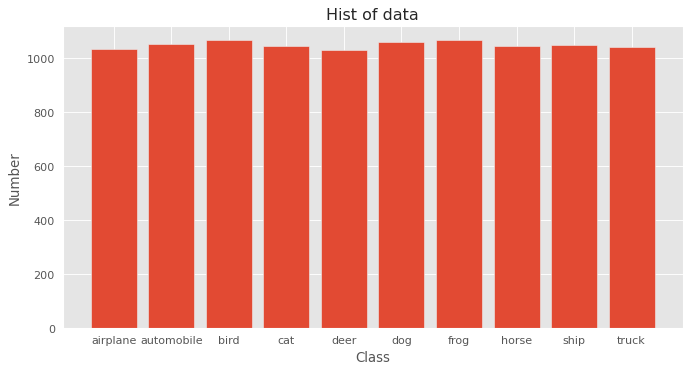

In [7]:
# 绘制train_data的分布情况
utils.draw_hist(train_data)

In [8]:
# 定义data_transform，和正常训练时保持一致
data_transform = {
        "train": transforms.Compose([
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.Resize(32),
                                    transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
        "val": transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])}


# 定义dataset
train_dataset = my_dataset.MyDataSet_CIFAR_Tracin(images_path=train_data,
                        transform=data_transform["train"])

val_dataset = my_dataset.MyDataSet_CIFAR_Tracin(images_path=val_data,
                        transform=data_transform["val"])


# 定义DataLoader类
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=nw,
                                            collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=nw,
                                            collate_fn=val_dataset.collate_fn)

In [9]:
len(train_loader)*batch_size

10560

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# 初始化模型
# model = ViT(
#     image_size = 32,
#     patch_size = 4,
#     num_classes = 10,
#     dim = 512,
#     depth = 6,
#     heads = 8,
#     mlp_dim = 512,
#     dropout = 0.1,
#     emb_dropout = 0.1
# ).to(device)

model = SimpleDLA().to(device)

In [12]:
# 定义损失函数和potimizer
# loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)

In [13]:
# 加载第 cp*10个checkpoint
checkpoint = torch.load('./weights_LDA/checkpoint-' + str(cp*10) + '.pth.tar')
    
model.load_state_dict(checkpoint['state_dict']) 
optimizer.load_state_dict(checkpoint['optimizer']) #加载优化器的参数

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
model.train()

SimpleDLA(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Tree(
    (root): Root(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (left_tree): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride

In [14]:
tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
best_acc = 0

In [15]:
# 训练（300 - 10*cp）个epoch
for epoch in range(250 - 10 * cp):
    
    model.train()
    accu_loss = torch.zeros(1).to(device)  # 累计损失
    accu_num = torch.zeros(1).to(device)  # 累计预测正确的样本数
    optimizer.zero_grad()

    sample_num = 0
    # data_loader = tqdm(train_loader)
    # 训练
    for step, data in enumerate(train_loader):
        images, labels, n = data

        sample_num += images.shape[0]

        pred = model(images.to(device))
        
        pred_classes = torch.max(pred, dim=1)[1]  # 预测的类别，[1]是标签索引
       
        
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()
        loss = loss_function(pred, labels.to(device))
        loss.backward()
        
        accu_loss += loss.detach()
        
        # data_loader.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch  + 10 * cp,
        #                                                                        accu_loss.item() / (step + 1),
        #                                                                        accu_num.item() / sample_num)
        optimizer.step()  # 更新
        optimizer.zero_grad()
    
    # 进行evaluate
    train_loss =  accu_loss.item() / (step + 1)
    train_acc = accu_num.item() / sample_num
    val_loss, val_acc = utils.evaluate(model=model,
                                data_loader=val_loader,
                                device=device,
                                epoch=epoch + 10 * cp,
                                print_info=(epoch%5==0))
    
    # 将每个epoch的数据保存到tensorboard
    writer.add_scalar(tags[0] + "_"+ description, train_loss, epoch + 10 * cp)
    # writer.add_scalar(tags[1] + "_" + str(cp*10) + description, train_acc, epoch + 10 * cp)
    writer.add_scalar(tags[2] + "_"+ description, val_loss, epoch + 10 * cp)
    writer.add_scalar(tags[3] + "_"+ description, val_acc, epoch + 10 * cp)
    # writer.add_scalar(tags[4] + "_" + str(cp*10) + description, optimizer.param_groups[0]["lr"], epoch + 10 * cp)
    if val_acc >= best_acc:
        best_acc = val_acc
        
        state = {
                    'epoch' : epoch + 1,  #保存当前的迭代次数
                    'state_dict' : model.state_dict(), #保存模型参数
                    'optimizer' : optimizer.state_dict()
                }

        torch.save(state, './best_model/' + description + '.pth.tar') 
        print("Best model is saved! Accuracy is {}".format(best_acc))
        
        
    scheduler.step()

[valid epoch 20] loss: 0.789, acc: 0.726: 100%|██████████| 79/79 [00:02<00:00, 34.76it/s]


Best model is saved! Accuracy is 0.7262
Best model is saved! Accuracy is 0.7364


[valid epoch 60] loss: 0.895, acc: 0.718: 100%|██████████| 79/79 [00:02<00:00, 35.26it/s]


Best model is saved! Accuracy is 0.7392


[valid epoch 65] loss: 0.803, acc: 0.740: 100%|██████████| 79/79 [00:02<00:00, 34.64it/s]


Best model is saved! Accuracy is 0.7398
Best model is saved! Accuracy is 0.7456


[valid epoch 70] loss: 0.886, acc: 0.728: 100%|██████████| 79/79 [00:02<00:00, 35.23it/s]


Best model is saved! Accuracy is 0.7578


[valid epoch 80] loss: 0.775, acc: 0.756: 100%|██████████| 79/79 [00:02<00:00, 35.41it/s]


Best model is saved! Accuracy is 0.7598


[valid epoch 90] loss: 0.858, acc: 0.731: 100%|██████████| 79/79 [00:02<00:00, 34.60it/s]


Best model is saved! Accuracy is 0.7822


[valid epoch 100] loss: 0.815, acc: 0.755: 100%|██████████| 79/79 [00:02<00:00, 34.70it/s]


Best model is saved! Accuracy is 0.7826


[valid epoch 110] loss: 0.641, acc: 0.793: 100%|██████████| 79/79 [00:02<00:00, 34.98it/s]


Best model is saved! Accuracy is 0.7934


[valid epoch 115] loss: 0.656, acc: 0.801: 100%|██████████| 79/79 [00:02<00:00, 34.21it/s]


Best model is saved! Accuracy is 0.801


[valid epoch 120] loss: 0.998, acc: 0.733: 100%|██████████| 79/79 [00:02<00:00, 34.77it/s]


Best model is saved! Accuracy is 0.8046


[valid epoch 130] loss: 0.756, acc: 0.785: 100%|██████████| 79/79 [00:02<00:00, 35.14it/s]


Best model is saved! Accuracy is 0.809


[valid epoch 140] loss: 0.745, acc: 0.792: 100%|██████████| 79/79 [00:02<00:00, 33.83it/s]


Best model is saved! Accuracy is 0.8108


[valid epoch 145] loss: 0.701, acc: 0.792: 100%|██████████| 79/79 [00:02<00:00, 34.49it/s]


Best model is saved! Accuracy is 0.8148


[valid epoch 150] loss: 0.720, acc: 0.805: 100%|██████████| 79/79 [00:02<00:00, 34.88it/s]


Best model is saved! Accuracy is 0.8264


[valid epoch 155] loss: 0.726, acc: 0.817: 100%|██████████| 79/79 [00:02<00:00, 35.30it/s]


Best model is saved! Accuracy is 0.8406


[valid epoch 165] loss: 0.662, acc: 0.838: 100%|██████████| 79/79 [00:02<00:00, 35.64it/s]


Best model is saved! Accuracy is 0.8406
Best model is saved! Accuracy is 0.8478


[valid epoch 170] loss: 0.640, acc: 0.840: 100%|██████████| 79/79 [00:02<00:00, 35.28it/s]


Best model is saved! Accuracy is 0.8492


[valid epoch 175] loss: 0.687, acc: 0.837: 100%|██████████| 79/79 [00:02<00:00, 35.71it/s]


Best model is saved! Accuracy is 0.8562


[valid epoch 185] loss: 0.625, acc: 0.856: 100%|██████████| 79/79 [00:02<00:00, 35.65it/s]


Best model is saved! Accuracy is 0.8564


[valid epoch 190] loss: 0.644, acc: 0.851: 100%|██████████| 79/79 [00:02<00:00, 34.48it/s]


Best model is saved! Accuracy is 0.8578


[valid epoch 200] loss: 0.635, acc: 0.855: 100%|██████████| 79/79 [00:02<00:00, 35.36it/s]


Best model is saved! Accuracy is 0.86


[valid epoch 230] loss: 0.625, acc: 0.859: 100%|██████████| 79/79 [00:02<00:00, 35.08it/s]


Best model is saved! Accuracy is 0.8606


[valid epoch 245] loss: 0.656, acc: 0.849: 100%|██████████| 79/79 [00:02<00:00, 35.66it/s]
